# Lottery Draw Analysis and Pattern Prediction

> **Important**: For reproducibility, please:
> 1. Restart the kernel (Runtime > Restart kernel)
> 2. Run all cells in order (Runtime > Run all)
> 3. Wait for each cell to complete before proceeding

This notebook analyzes lottery draw data to identify patterns and predict potential future draws. It includes:
- Automated data downloading and preparation
- Pattern analysis with visualizations
- Machine learning-based pattern prediction

In [198]:
# Install required packages
%pip install -q pandas seaborn matplotlib requests joblib scikit-learn tqdm

# Required imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from tqdm.notebook import tqdm  # For progress bars in loops
import requests
import zipfile
import os
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Setup
The next cell will install required packages and set up the environment. Choose your environment:
- 'fdj': French National Lottery (full dataset)
- 'em': EuroMillions (full dataset)

In [167]:
# ENVIRONMENTS SETUP
ENVIRONMENTS = {
    "fdj": {  # French National Lottery
        "url_to_zip": "https://media.fdj.fr/static-draws/csv/loto/loto_201911.zip",
        "file_name": "loto_201911.csv",
        "max_number": 49,
    },
    "em": {  # EuroMillions
        "url_to_zip": "https://media.fdj.fr/static-draws/csv/euromillions/euromillions_202002.zip",
        "file_name": "euromillions_202002.csv",
        "max_number": 50,
    },

}

# Select environment (change this to switch between environments)
ENV = "fdj"  # Options: "fdj", "em"
config = ENVIRONMENTS[ENV]

# Extract configuration
url_to_zip = config["url_to_zip"]
file_name = config["file_name"]
max_number = config["max_number"]

print(f"Selected environment: {ENV}")
print(f"Using file: {file_name}")
print(f"Maximum number: {max_number}")

Selected environment: fdj
Using file: loto_201911.csv
Maximum number: 49


## Data Loading and Processing

This section:
1. Downloads the lottery data ZIP file from the configured URL
2. Extracts the CSV file
3. Loads the data into a pandas DataFrame
4. Processes the relevant columns (boule_1 through boule_5, numero_chance if available)

The data processing is configured based on the selected environment (FDJ or EuroMillions).

In [168]:
def download_and_extract_zip(url, destination_folder):
    """
    Downloads a zip file from the given URL and extracts its contents.
    
    Args:
        url (str): URL of the zip file to download
        destination_folder (str): Where to extract the contents
        
    Returns:
        bool: True if successful, False otherwise
    """
    print(f"Downloading from {url}...")
    try:
        response = requests.get(url, timeout=30)
        
        if response.status_code == 404:
            print("❌ File not found (404)")
            return False
        elif response.status_code == 200:
            zip_filename = "downloaded_file.zip"
            with open(zip_filename, 'wb') as f:
                f.write(response.content)

            print("Extracting files...")
            with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
                zip_ref.extractall(destination_folder)

            os.remove(zip_filename)
            print(f"✓ Successfully downloaded and extracted to {destination_folder}")
            return True
        else:
            print(f"❌ Failed to download. Status code: {response.status_code}")
            return False
            
    except Exception as e:
        print(f"❌ Error: {str(e)}")
        return False

# Download the lottery data
if download_and_extract_zip(url_to_zip, "./"):
    print("✓ Data ready for processing")
else:
    print("❌ Failed to prepare data")

Extracting files...
✓ Successfully downloaded and extracted to ./
✓ Data ready for processing


In [230]:
# Create a DataFrame with all possible numbers from 1 to 49 inclusive
all_numbers = pd.DataFrame({'number': range(1, max_number + 1)})

try:
    df = pd.read_csv(file_name, sep=";", encoding="utf-8")
except UnicodeDecodeError:
    # Try with a common alternative encoding for French/Euro files
    df = pd.read_csv(file_name, sep=";", encoding="latin1")

if ENV == "fdj":
    df = df[['boule_1', 'boule_2', 'boule_3', 'boule_4', 'boule_5', 'numero_chance', 'date_de_tirage']]
else:
    df = df[['boule_1', 'boule_2', 'boule_3', 'boule_4', 'boule_5', 'date_de_tirage']]

df.head(20)

,boule_1,boule_2,boule_3,boule_4,boule_5,numero_chance,date_de_tirage
0,40,11,18,8,47,2,24/07/2024
1,49,35,25,27,42,9,22/07/2024
2,5,30,16,47,15,7,20/07/2024
3,35,40,17,6,47,4,17/07/2024
4,4,10,30,38,24,10,15/07/2024
5,21,5,6,24,42,8,13/07/2024
6,16,3,5,39,11,9,10/07/2024
7,7,42,31,8,24,6,08/07/2024
8,46,13,47,18,34,5,06/07/2024
9,4,1,24,21,42,3,03/07/2024


In [237]:
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from typing import Union, List, Optional, Any

class PatternPlotter:
    """
    Analyzes and visualizes lottery number patterns using color-coded ranges.
    """
    def __init__(self, draw_data: pd.DataFrame, boule_cols: List[str] = None):
        """
        Initialize the pattern analyzer.
        
        Args:
            draw_data: DataFrame containing lottery draw numbers
            boule_cols: List of column names containing the drawn numbers
        """
        self.df = draw_data
        self.boule_cols = boule_cols or ['boule_1', 'boule_2', 'boule_3', 'boule_4', 'boule_5']
        self.colors = {
            'green': '#8de5a1',   # 1-10
            'yellow': '#ffd92f',  # 11-20
            'red': '#f77189',     # 21-30
            'purple': '#bb83f4',  # 31-40
            'blue': '#3ba3ec'     # 41-49/50
        }
        
        # Initialize pattern data
        self.categorized_df = None
        self.pattern_counts = None
        self._analyze_patterns()
        
    def _get_color(self, x: float) -> str:
        """Convert a number to its corresponding color category."""
        if pd.isna(x):
            return 'unknown'
        x = int(x)
        if x <= 10:
            return 'green'
        elif x <= 20:
            return 'yellow'
        elif x <= 30:
            return 'red'
        elif x <= 40:
            return 'purple'
        else:
            return 'blue'

    print("Categorizing numbers...")
    # Convert numbers to colors
    colors = np.vectorize(get_color)(numbers)
    categorized_df = pd.DataFrame(colors, columns=pd.Index(existing_boule_cols), index=df.index)

    # Create patterns
    print("Creating patterns...")
    # tqdm causes ImportError: IProgress not found in some Jupyter environments.
    # We'll use a simple for loop instead.

    patterns = []
    print("Creating patterns (no progress bar)...")
    for row in colors:
        patterns.append('-'.join(row))
    categorized_df['Pattern'] = patterns

    # Get statistics
    print("Analyzing frequencies...")
    pattern_counts = pd.Series(patterns).value_counts()

    print("\nMost common patterns:")
    display(pattern_counts.head(10))


Analyzing patterns...
Categorizing numbers...
Creating patterns...
Creating patterns (no progress bar)...
Analyzing frequencies...

Most common patterns:


green-yellow-red-purple-blue      37
green-green-yellow-purple-blue    23
green-green-yellow-red-blue       21
green-yellow-yellow-red-blue      20
green-yellow-purple-blue-blue     19
yellow-red-purple-purple-blue     19
green-yellow-yellow-red-purple    18
yellow-yellow-red-purple-blue     18
green-yellow-red-red-blue         18
green-green-yellow-red-purple     17
Name: count, dtype: int64

In [ ]:
# Required imports for pattern analysis
from typing import Union, List, Optional, Any
from collections.abc import Sequence
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


In [ ]:
class PatternAnalyzer:
    """
    Analyzes and visualizes lottery number patterns using color-coded ranges.
    """
    def __init__(self, draw_data: pd.DataFrame, boule_cols: Optional[Sequence[str]] = None):
        """
        Initialize the pattern analyzer.
        
        Args:
            draw_data: DataFrame containing lottery draw numbers
            boule_cols: List of column names containing the drawn numbers
        """
        if not isinstance(draw_data, pd.DataFrame):
            raise TypeError("draw_data must be a pandas DataFrame")
            
        self.df = draw_data
        self.boule_cols = list(boule_cols) if boule_cols is not None else ['boule_1', 'boule_2', 'boule_3', 'boule_4', 'boule_5']
        self.colors = {
            'green': '#8de5a1',   # 1-10
            'yellow': '#ffd92f',  # 11-20
            'red': '#f77189',     # 21-30
            'purple': '#bb83f4',  # 31-40
            'blue': '#3ba3ec'     # 41-49/50
        }
        
        # Initialize pattern data
        self.categorized_df: Optional[pd.DataFrame] = None
        self.pattern_counts: Optional[pd.Series] = None
        self._analyze_patterns()
        
    def _get_color(self, x: float) -> str:
        """Convert a number to its corresponding color category."""
        if pd.isna(x):
            return 'unknown'
        x = int(x)
        if x <= 10:
            return 'green'
        elif x <= 20:
            return 'yellow'
        elif x <= 30:
            return 'red'
        elif x <= 40:
            return 'purple'
        else:
            return 'blue'
            
    def _analyze_patterns(self) -> None:
        """Analyze patterns in the lottery draw data."""
        print("Analyzing patterns...")
        
        # Verify columns exist
        existing_cols = [col for col in self.boule_cols if col in self.df.columns]
        if not existing_cols:
            raise ValueError("None of the specified boule columns found in DataFrame")
            
        # Convert to numpy array and sort each row
        numbers = np.asarray(self.df[existing_cols])
        numbers.sort(axis=1)
        
        # Create sorted DataFrame
        sorted_df = pd.DataFrame(
            numbers, 
            columns=pd.Index(existing_cols), 
            index=self.df.index
        )
        
        print("Categorizing numbers...")
        # Convert numbers to colors
        colors = np.vectorize(self._get_color)(numbers)
        self.categorized_df = pd.DataFrame(
            colors,
            columns=pd.Index(existing_cols),
            index=self.df.index
        )
        
        print("Creating patterns...")
        # Create pattern strings
        patterns = ['-'.join(row) for row in colors]
        if self.categorized_df is not None:  # Type guard
            self.categorized_df['Pattern'] = patterns
        
        # Calculate pattern frequencies
        print("Analyzing frequencies...")
        self.pattern_counts = pd.Series(patterns).value_counts()
        
    def plot_patterns(self, patterns: Optional[Union[pd.DataFrame, List[str], pd.Series]] = None,
                     counts: Optional[pd.Series] = None,
                     figsize: tuple = (4, None),
                     show_counts: bool = True,
                     title: Optional[str] = None) -> None:
        """
        Display patterns as colored rectangles.
        
        Args:
            patterns: Optional specific patterns to plot (defaults to all patterns)
            counts: Optional pattern counts (defaults to analyzed counts)
            figsize: Figure size (width, height)
            show_counts: Whether to show occurrence counts
            title: Custom title for the plot
        """
        if self.categorized_df is None:
            raise ValueError("No patterns analyzed yet. Run _analyze_patterns() first.")
            
        # Use provided patterns or default to all patterns
        if patterns is None:
            patterns = self.categorized_df[['Pattern']]
        
        # Convert input to DataFrame
        if isinstance(patterns, pd.Series):
            df = pd.DataFrame({'Pattern': patterns})
        elif isinstance(patterns, list):
            df = pd.DataFrame({'Pattern': patterns})
        else:
            df = patterns
            
        # Use provided counts or default to analyzed counts
        pattern_counts = counts if counts is not None else self.pattern_counts
        
        n_rows = len(df)
        if figsize[1] is None:
            figsize = (figsize[0], n_rows / 2)
            
        # Adjust figure size if showing counts
        if show_counts:
            figsize = (figsize[0] + 1.5, figsize[1])
            
        fig, ax = plt.subplots(figsize=figsize)

        for idx in range(n_rows):
            row = df.iloc[idx]
            pattern = row['Pattern'] if isinstance(row, pd.Series) else row
            pattern_colors = str(pattern).split('-')
            
            # Plot pattern rectangles
            for i, color in enumerate(pattern_colors):
                rect = patches.Rectangle(
                    (i, n_rows - idx - 1), 1, 1,
                    edgecolor='black',
                    facecolor=self.colors[color]
                )
                ax.add_patch(rect)
            
            # Add count if available
            if show_counts and pattern_counts is not None:
                count = pattern_counts.get(pattern, 0)
                ax.text(5.2, n_rows - idx - 0.5, f'× {count}',
                       verticalalignment='center',
                       fontsize=10)

        # Customize plot
        ax.set_xlim(0, 6.5 if show_counts else 5)
        ax.set_ylim(0, n_rows)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlabel('')
        ax.set_ylabel('')
        
        if title:
            plt.title(title)
        
        plt.show()
        
    def show_recent_patterns(self, n: int = 15) -> None:
        """Show the n most recent patterns."""
        if self.categorized_df is None:
            raise ValueError("No patterns analyzed yet")
            
        print(f"\nLast {n} Draw Patterns:")
        recent_patterns = self.categorized_df[['Pattern']].head(n)
        self.plot_patterns(recent_patterns, title=f'Last {n} Draws')
        
    def show_common_patterns(self, n: int = 10) -> None:
        """Show the n most common patterns."""
        if self.pattern_counts is None:
            raise ValueError("No patterns analyzed yet")
            
        print(f"\nTop {n} Most Common Patterns:")
        top_patterns = self.pattern_counts.head(n)
        self.plot_patterns(
            pd.DataFrame({'Pattern': top_patterns.index}),
            top_patterns,
            title=f'Top {n} Most Frequent Patterns'
        )
        
    def get_pattern_stats(self) -> None:
        """Display basic pattern statistics."""
        if self.pattern_counts is None:
            raise ValueError("No patterns analyzed yet")
            
        print("\nPattern Statistics:")
        print(f"Total unique patterns: {len(self.pattern_counts)}")
        print(f"Most common pattern: {self.pattern_counts.index[0]} ({self.pattern_counts.iloc[0]} times)")
        print(f"Least common pattern: {self.pattern_counts.index[-1]} ({self.pattern_counts.iloc[-1]} times)")

# Create pattern analyzer and show results
print("Initializing pattern analysis...")
analyzer = PatternAnalyzer(df)

# Show pattern statistics
analyzer.get_pattern_stats()

# Show visualizations
analyzer.show_recent_patterns(15)
analyzer.show_common_patterns(10)


## Heatmap Visualization

The heatmap shows the frequency of each number's appearance in the lottery draws:
- X-axis: Numbers from 1 to max_number
- Color intensity: Higher intensity = more frequent occurrence
- Numbers in cells: Exact count of appearances

We analyze different time ranges to identify both long-term and recent trends:
- Last 5 draws: Very recent patterns
- Last 15 draws: Short-term trends
- Last 50 draws: Medium-term patterns
- All draws: Long-term frequency distribution

This helps identify "hot" (frequently drawn) and "cold" (rarely drawn) numbers over different time periods.

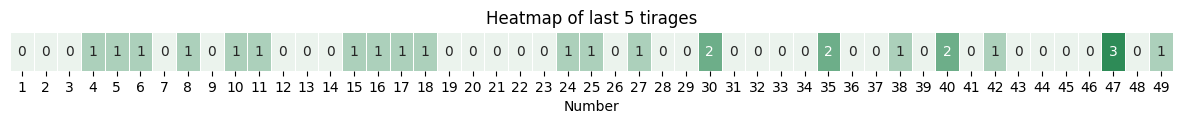

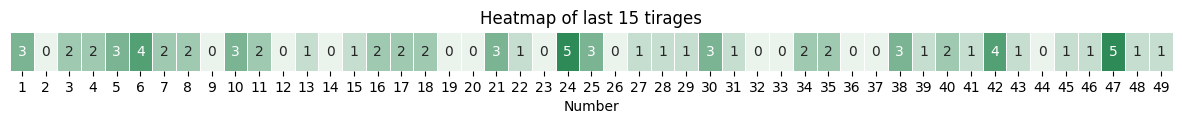

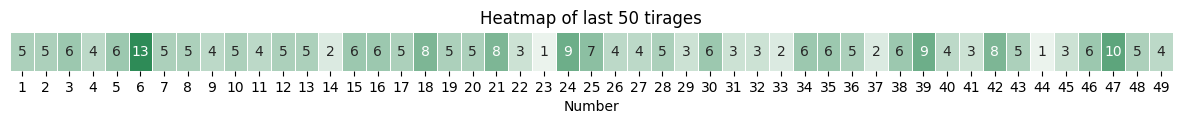

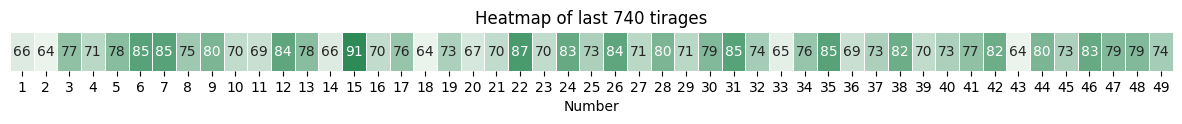

In [238]:
# HEATMAP
def extract_data_frame(data_frame, first_n_rows=None):
    """
    Returns a copy of the first_n_rows of the DataFrame, or the whole DataFrame if first_n_rows is None.
    """
    if first_n_rows is None:
        return data_frame.copy()
    return data_frame.iloc[:first_n_rows].copy()

def show_heat_map(last_tirages=None):
    """
    Displays a heatmap of the frequency of each number (1-max_number) in the last `last_tirages` draws.
    If last_tirages is None, uses all available draws.
    Handles KeyError if boule columns are missing.
    """
    extracted_df = extract_data_frame(df, last_tirages)
    boule_cols = ['boule_1', 'boule_2', 'boule_3', 'boule_4', 'boule_5']

    # Check if all boule columns exist in the DataFrame
    missing_cols = [col for col in boule_cols if col not in extracted_df.columns]
    if missing_cols:
        print(f"Warning: The following columns are missing in the DataFrame and will be skipped: {missing_cols}")
        boule_cols = [col for col in boule_cols if col in extracted_df.columns]
        if not boule_cols:
            print("Error: No boule columns found in the DataFrame. Cannot plot heatmap.")
            return

    # Only melt if there are valid boule columns
    flat_df = extracted_df.melt(value_vars=boule_cols, var_name='boule', value_name='number')

    tirages_count = len(extracted_df)

    # Count occurrences of each number
    number_counts = flat_df['number'].value_counts().reindex(range(1, max_number+1), fill_value=0).sort_index()

    plt.figure(figsize=(15, 0.5))
    sns.heatmap(
        np.array(number_counts.values).reshape(1, -1),
        cmap=sns.light_palette("seagreen", as_cmap=True),
        annot=True,
        fmt='d',
        linewidths=.5,
        cbar=False,
        xticklabels=[str(x) for x in number_counts.index]
    )
    plt.title(f'Heatmap of last {tirages_count} tirages')
    plt.yticks([])
    plt.xlabel('Number')
    plt.show()

# Example usage
for n in [5, 15, 50, None]:
    show_heat_map(n)

### Pattern Visualization Explanation

The visualizations above show:

1. **Color Legend**: Shows what each color represents in terms of number ranges.
   - Each rectangle represents a range of 10 numbers
   - Colors progress from green (lowest) to blue (highest)

2. **Recent Draw Patterns**: Shows the last 20 draws
   - Each row represents one draw
   - Most recent draws are at the top
   - Each rectangle in a row represents one number's range

3. **Most Common Patterns**: Shows the 10 most frequent patterns
   - Each row is a unique pattern
   - Most frequent patterns are at the top
   - Helps identify common number range distributions

These visualizations help identify trends in how numbers are distributed across ranges in winning draws.

Color Legend for Number Ranges:


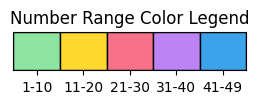


Recent Draw Patterns:


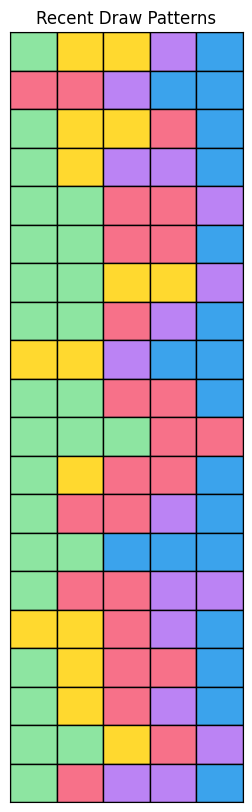


Most Common Patterns:


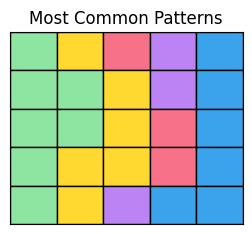

In [239]:
class ColorLegend:
    """
    Creates and displays a color legend for number ranges.
    """
    def __init__(self):
        self.colors = ['#8de5a1', '#ffd92f', '#f77189', '#bb83f4', '#3ba3ec']
        self.ranges = ['1-10', '11-20', '21-30', '31-40', f'41-{max_number}']
        
    def plot(self, figsize=(3, 0.5)):
        """Display the color legend with number ranges."""
        fig, ax = plt.subplots(figsize=figsize)
        
        # Create color rectangles
        for i, (color, label) in enumerate(zip(self.colors, self.ranges)):
            rect = mpatches.Rectangle(
                (i, 0), 1, 1,
                facecolor=color,
                edgecolor='black'
            )
            ax.add_patch(rect)
        
        # Customize plot
        ax.set_xlim(0, len(self.colors))
        ax.set_ylim(0, 1)
        ax.set_xticks([i + 0.5 for i in range(len(self.colors))])
        ax.set_xticklabels(self.ranges)
        ax.set_yticks([])
        plt.title('Number Range Color Legend')
        plt.show()

class PatternPlotter:
    """
    Visualizes lottery draw patterns using color-coded rectangles.
    """
    def __init__(self, patterns, title, max_patterns=20):
        """
        Args:
            patterns (list): List of color patterns (e.g., ['green-yellow-red-purple-blue', ...])
            max_patterns (int): Maximum number of patterns to display
        """
        self.patterns = patterns[:max_patterns]
        self.title = title
        self.colors = {
            'green': '#8de5a1',
            'yellow': '#ffd92f',
            'red': '#f77189',
            'purple': '#bb83f4',
            'blue': '#3ba3ec'
        }
        
    def plot(self, figsize=None):
        """Display the patterns as colored rectangles."""
        n_patterns = len(self.patterns)
        if n_patterns == 0:
            print("No patterns to display.")
            return

        # Set default figsize: height=0.5 (like ColorLegend) if only one pattern, else 0.5 per pattern
        if figsize is None:
            # If only one pattern, use (3, 0.5) like ColorLegend; else, (3, n_patterns*0.5)
            height = max(0.5, n_patterns * 0.5)
            figsize = (3, height)
            
        fig, ax = plt.subplots(figsize=figsize)
        
        # Plot each pattern
        for i, pattern in enumerate(self.patterns):
            colors = pattern.split('-')
            for j, color in enumerate(colors):
                rect = mpatches.Rectangle(
                    (j, n_patterns - i - 1), 1, 1,
                    facecolor=self.colors[color],
                    edgecolor='black'
                )
                ax.add_patch(rect)
        
        # Customize plot
        ax.set_xlim(0, 5)  # 5 numbers per draw
        ax.set_ylim(0, n_patterns)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.title(self.title)
        plt.show()

# Display the legend
print("Color Legend for Number Ranges:")
ColorLegend().plot()

# Display recent patterns
print("\nRecent Draw Patterns:")
recent_patterns = categorized_df['Pattern'].head(20).tolist()
# Use same height as ColorLegend (0.5) for each pattern
PatternPlotter(recent_patterns, title='Recent Draw Patterns').plot(figsize=(3, len(recent_patterns)*0.5))

# Display most common patterns
print("\nMost Common Patterns:")
common_patterns = pattern_counts.head(5).index.tolist()
# Use same height as ColorLegend (0.5) for each pattern
PatternPlotter(common_patterns, title='Most Common Patterns').plot(figsize=(3, len(common_patterns)*0.5))


## Machine Learning Pattern Prediction

This section uses a Decision Tree Classifier to predict potential future patterns based on historical data. The process:

1. **Data Preparation**
   - Convert color patterns to numerical values
   - Create features from historical patterns
   - Split data into training and test sets

2. **Model Training**
   - Train a Decision Tree Classifier
   - Evaluate accuracy on test data
   - Save model for future use

3. **Prediction**
   - Use the trained model to predict the next likely pattern
   - Visualize the predicted pattern

Note: This is for analysis purposes only. Past patterns do not guarantee future results.

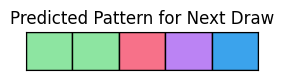

In [240]:
# These imports are specific to the machine learning section and are best kept here, 
# close to where they are used for clarity and modularity.
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import joblib   

# Map color names to integer codes for model input
COLOR_MAPPING = {'green': 0, 'yellow': 1, 'red': 2, 'purple': 3, 'blue': 4}
REVERSE_COLOR_MAPPING = {v: k for k, v in COLOR_MAPPING.items()}

def encode_pattern(pattern_str, color_mapping):
    """Convert a pattern string to a list of integer codes."""
    return [color_mapping[color] for color in pattern_str.split('-')]

def decode_pattern(encoded_pattern, reverse_mapping):
    """Convert a list of integer codes back to a pattern string."""
    return '-'.join([reverse_mapping[int(x)] for x in encoded_pattern])

# Prepare DataFrame from categorized patterns
data = {
    'Pattern': categorized_df['Pattern']
}
df = pd.DataFrame(data)

# Encode patterns as lists of integers
df['PatternEncoded'] = df['Pattern'].apply(lambda x: encode_pattern(x, COLOR_MAPPING))

# Prepare features (X) and targets (y) for supervised learning
# X: all but last pattern, y: next pattern (shifted up by 1)
X = df['PatternEncoded'].iloc[:-1].tolist()
y = df['PatternEncoded'].shift(-1).dropna().tolist()

# Split into training and test sets for evaluation
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Train Decision Tree Classifier
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

# Save the trained model for future use
joblib.dump(clf, 'pattern-oracle.joblib')
# To load: clf = joblib.load('pattern-oracle.joblib')

# Evaluate model on test set
y_pred_test = clf.predict(X_test)

# Flatten lists for accuracy calculation
y_pred_test_flat = [item for sublist in y_pred_test for item in sublist]
y_test_flat = [item for sublist in y_test for item in sublist]

accuracy = accuracy_score(y_test_flat, y_pred_test_flat)
# print(f'Test Set Accuracy: {accuracy:.4f}')  # Suppressed as per instruction

# Predict the next pattern based on the most recent pattern
first_row_features = np.array(df['PatternEncoded'].iloc[0]).reshape(1, -1)
predicted_pattern = clf.predict(first_row_features)[0]
predicted_pattern_str = decode_pattern(predicted_pattern, REVERSE_COLOR_MAPPING)

# print("Predicted pattern for next draw:")  # Suppressed as per instruction
# Visualize the predicted pattern
predicted_df = pd.DataFrame({'Pattern': [predicted_pattern_str]})
PatternPlotter([predicted_pattern_str], title="Predicted Pattern for Next Draw").plot(figsize=(3, 0.5))